# Setup

In [ ]:
pip install shap

     |████████████████████████████████| 564 kB 7.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from scipy import stats
from sklearn import tree, ensemble, model_selection, metrics

from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import shap

from datetime import datetime


from scipy.stats import uniform
from sklearn.svm import SVC
import xgboost as xgb

from numpy.random import seed
seed(2022)

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data Modelling/Stock Prices Prediction/train.csv')
#df = df[['date','retweets', 'likes', 'Software', 'Cloud',
#       'Work', 'Humor', 'Woman', 'Partnership', 'Community', 'Improvement',
#       'symbol', 'marketCap', 'peRatio', 'eps',
#       'sentiment','vol_diff_lead', 'change_lead']]
train

X_train = train.drop("change_lead", axis = 1)
y_train = train["change_lead"]

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Data Modelling/Stock Prices Prediction/test.csv')
#df = df[['date','retweets', 'likes', 'Software', 'Cloud',
#       'Work', 'Humor', 'Woman', 'Partnership', 'Community', 'Improvement',
#       'symbol', 'marketCap', 'peRatio', 'eps',
#       'sentiment','vol_diff_lead', 'change_lead']]

X_test = test.drop("change_lead", axis = 1)
y_test = test["change_lead"]
y_test

0      1
1      1
2      1
3      1
4      1
      ..
271    0
272    1
273    1
274    1
275    0
Name: change_lead, Length: 276, dtype: int64

In [ ]:
# Seed value
seed_value= 2022

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Helper function

In [ ]:
agg_accuracy_score_dict = {}
agg_f1_score_dict={}
agg_roc_auc_dict={}

train_accuracy_score_dict = {}
train_f1_score_dict={}
train_roc_auc_dict={}

val_accuracy_score_dict = {}
val_f1_score_dict={}
val_roc_auc_dict={}

test_accuracy_score_dict = {}
test_f1_score_dict={}
test_roc_auc_dict={}

def evaluation(true, pred, title):
    print("================== Evaluation on {} ==================".format(title))
    # accuracy 
    acc = accuracy_score(true, pred)
    print("accuracy: {}\n".format(acc))
    agg_accuracy_score_dict[title] = acc
    # f1 score
    print("classification report: \n{}\n".format(classification_report(true, pred)))
    print("F1 score: \n{}\n".format(metrics.f1_score(true, pred)))
    f1 = f1_score(true, pred)
    agg_f1_score_dict[title] = f1
    # confusion matrix
    print("Confusion matrix: \n{}\n".format(confusion_matrix(true, pred)))
    # roc auc result
    fpr, tpr, thresholds = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC: {}\n".format(roc_auc))
    agg_roc_auc_dict[title] = roc_auc

    precision = metrics.precision_score(true,pred)
    print("Precision: {}\n".format(precision))
    print("================== End of Evaluation on {} ==================".format(title))
    
    if "train dataset" in title:
        train_accuracy_score_dict[title] = acc
        train_f1_score_dict[title] = f1
        train_roc_auc_dict[title] = roc_auc
    elif "test dataset" in title:
        test_accuracy_score_dict[title] = acc
        test_f1_score_dict[title] = f1
        test_roc_auc_dict[title] = roc_auc
    else:
        val_accuracy_score_dict[title] = acc
        val_f1_score_dict[title] = f1
        val_roc_auc_dict[title] = roc_auc

In [ ]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

# Base RF model

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=500, random_state=2022, min_samples_leaf=1, min_samples_split=5, max_depth=10)
rf.fit(X_train, y_train)

evaluation(y_train, rf.predict(X_train), "Default rf on train dataset")

y_pred_class = rf.predict(X_test)
evaluation(y_test, y_pred_class, "Default rf on test dataset")

================== Evaluation on Default rf on train dataset ==================
accuracy: 0.814993954050786

classification report: 
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1193
           1       0.78      0.89      0.83      1288

    accuracy                           0.81      2481
   macro avg       0.82      0.81      0.81      2481
weighted avg       0.82      0.81      0.81      2481


F1 score: 
0.833393829401089

Confusion matrix: 
[[ 874  319]
 [ 140 1148]]

ROC AUC: 0.8119556106272094

================== End of Evaluation on Default rf on train dataset ==================
================== Evaluation on Default rf on test dataset ==================
accuracy: 0.5253623188405797

classification report: 
              precision    recall  f1-score   support

           0       0.59      0.36      0.45       147
           1       0.49      0.71      0.58       129

    accuracy                           0.53      

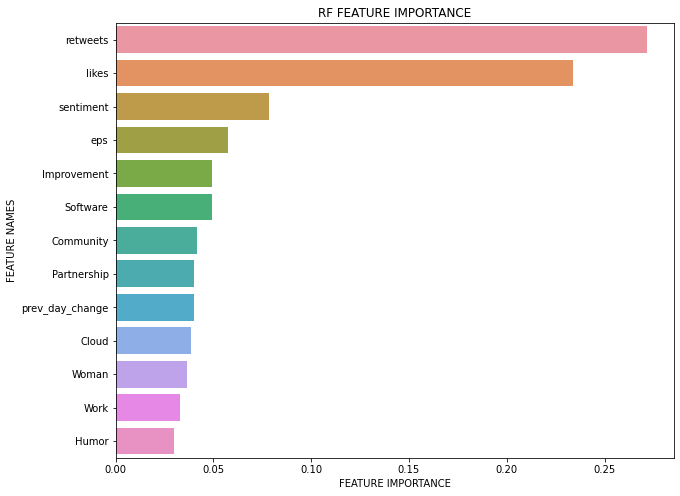

In [ ]:
plot_feature_importance(rf.feature_importances_, list(X_train.columns),'RF ')

# hyperparam tuning

## using gridsearch

In [ ]:
parameters = {
    'max_depth': range(1, 20, 1),
    'n_estimators': range(10, 100, 10),
    'min_samples_split' : range(1,10,1),
    'max_features':['auto','sqrt'],
    'min_samples_leaf' : [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
rf = ensemble.RandomForestClassifier(random_state=2022)

In [ ]:
tuned_rf_model = GridSearchCV(
    estimator=rf,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 3,
    verbose=True
)

In [ ]:
searched_rf_model = tuned_rf_model.fit(X_train, y_train)

Fitting 3 folds for each of 18468 candidates, totalling 55404 fits



6156 fits failed out of a total of 55404.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3078 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/pyt

In [ ]:
searched_rf_model.best_params_

{'bootstrap': False,
 'max_depth': 1,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [ ]:
y_train_rf_tuned_predict = searched_rf_model.best_estimator_.predict(X_train)
evaluation(y_train, y_train_rf_tuned_predict, "Tuned rf on train dataset")

y_test_rf_tuned_predict = searched_rf_model.best_estimator_.predict(X_test)
evaluation(y_test, y_test_rf_tuned_predict, "Tuned rf on test dataset")

================== Evaluation on Tuned rf on train dataset ==================
accuracy: 0.5268037081821846

classification report: 
              precision    recall  f1-score   support

           0       0.55      0.08      0.14      1193
           1       0.52      0.94      0.67      1288

    accuracy                           0.53      2481
   macro avg       0.54      0.51      0.41      2481
weighted avg       0.54      0.53      0.42      2481


F1 score: 
0.673162583518931

Confusion matrix: 
[[  98 1095]
 [  79 1209]]

ROC AUC: 0.5104052235348019

Precision: 0.5247395833333334

================== End of Evaluation on Tuned rf on train dataset ==================
================== Evaluation on Tuned rf on test dataset ==================
accuracy: 0.47101449275362317

classification report: 
              precision    recall  f1-score   support

           0       0.60      0.02      0.04       147
           1       0.47      0.98      0.63       129

    accuracy          

## using manual tuning

In [ ]:
def all_metrics(true,pred,iterno):
  acc = metrics.accuracy_score(true, pred)
  f1 = metrics.f1_score(true, pred)
  fpr, tpr, thresholds = metrics.roc_curve(true, pred)
  roc_auc = metrics.auc(fpr,tpr)
  precision = metrics.precision_score(true, pred)
  recall = metrics.recall_score(true,pred)
  return {'iter':iterno,'acc':acc, 'f1':f1, 'roc':roc_auc, 'precision':precision, 'recall':recall}

### n_estimators : best = 10

In [ ]:
# n_estimators
trainstats = []
teststats = []
for i in range(10, 220, 10):
  rf = ensemble.RandomForestClassifier(random_state=2022, n_estimators=i)
  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)

  trainmetrics = all_metrics(y_train, y_train_pred, i)
  testmetrics = all_metrics(y_test, y_test_pred, i)

  trainstats.append(trainmetrics)
  teststats.append(testmetrics)

In [ ]:
teststatsdf = pd.DataFrame.from_records(teststats)
teststatsdf = teststatsdf.set_index('iter')
teststatsdf

,acc,f1,roc,precision,recall
iter,,,,,
10,0.561594,0.546816,0.561857,0.528986,0.565891
20,0.525362,0.537102,0.529268,0.493506,0.589147
30,0.500000,0.517483,0.504509,0.471338,0.573643
40,0.500000,0.517483,0.504509,0.471338,0.573643
50,0.510870,0.532872,0.516137,0.481250,0.596899
60,0.510870,0.536082,0.516611,0.481481,0.604651
70,0.507246,0.537415,0.513685,0.478788,0.612403
80,0.521739,0.554054,0.528714,0.491018,0.635659
90,0.510870,0.539249,0.517086,0.481707,0.612403


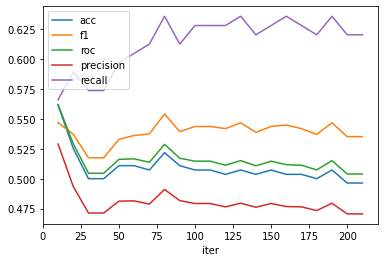

In [ ]:
teststatsdf.plot()
plt.show()

### max_depth: best=7

In [ ]:
# max_depth
trainstats = []
teststats = []
for i in range(1, 20, 1):
  rf = ensemble.RandomForestClassifier(random_state=2022, n_estimators=10, max_depth=i)
  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)

  trainmetrics = all_metrics(y_train, y_train_pred, i)
  testmetrics = all_metrics(y_test, y_test_pred, i)

  trainstats.append(trainmetrics)
  teststats.append(testmetrics)

In [ ]:
teststatsdf = pd.DataFrame.from_records(teststats)
teststatsdf = teststatsdf.set_index('iter')
teststatsdf

,acc,f1,roc,precision,recall
iter,,,,,
1,0.492754,0.648241,0.523810,0.479554,1.000000
2,0.500000,0.616667,0.522069,0.480519,0.860465
3,0.481884,0.578171,0.498893,0.466667,0.759690
4,0.503623,0.593472,0.520250,0.480769,0.775194
5,0.474638,0.515050,0.482123,0.452941,0.596899
6,0.489130,0.546624,0.499525,0.467033,0.658915
7,0.543478,0.606250,0.556241,0.507853,0.751938
8,0.528986,0.585987,0.540263,0.497297,0.713178
9,0.485507,0.485507,0.487581,0.455782,0.519380


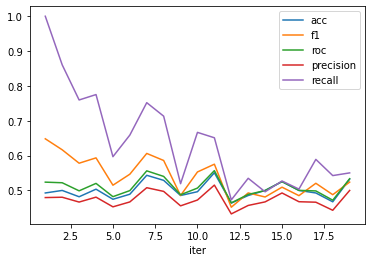

In [ ]:
teststatsdf.plot()
plt.show()

### min_samples_split: best = 7

In [ ]:
# min_samples_split
trainstats = []
teststats = []
for i in range(2, 10, 1):
  rf = ensemble.RandomForestClassifier(random_state=2022, n_estimators=10, max_depth=7, min_samples_split=i)
  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)

  trainmetrics = all_metrics(y_train, y_train_pred, i)
  testmetrics = all_metrics(y_test, y_test_pred, i)

  trainstats.append(trainmetrics)
  teststats.append(testmetrics)

In [ ]:
teststatsdf = pd.DataFrame.from_records(teststats)
teststatsdf = teststatsdf.set_index('iter')
teststatsdf

,acc,f1,roc,precision,recall
iter,,,,,
2,0.543478,0.606250,0.556241,0.507853,0.751938
3,0.550725,0.607595,0.562569,0.513369,0.744186
4,0.518116,0.533333,0.522465,0.487179,0.589147
5,0.525362,0.549828,0.531166,0.493827,0.620155
6,0.518116,0.566775,0.527685,0.488764,0.674419
7,0.543478,0.611111,0.557190,0.507692,0.767442
8,0.474638,0.511785,0.481648,0.452381,0.589147
9,0.507246,0.561290,0.517481,0.480663,0.674419


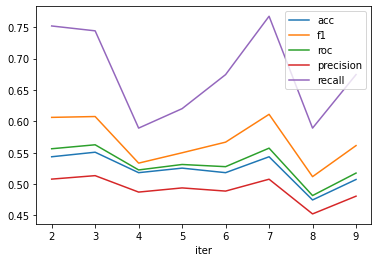

In [ ]:
teststatsdf.plot()
plt.show()

### min_samples_leaf: best=5

In [ ]:
# min_samples_leaf
trainstats = []
teststats = []
for i in range(1, 10, 1):
  rf = ensemble.RandomForestClassifier(random_state=2022, n_estimators=10, max_depth=7, min_samples_split=7, min_samples_leaf=i)
  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)

  trainmetrics = all_metrics(y_train, y_train_pred, i)
  testmetrics = all_metrics(y_test, y_test_pred, i)

  trainstats.append(trainmetrics)
  teststats.append(testmetrics)

In [ ]:
teststatsdf = pd.DataFrame.from_records(teststats)
teststatsdf = teststatsdf.set_index('iter')
teststatsdf

,acc,f1,roc,precision,recall
iter,,,,,
1,0.543478,0.611111,0.557190,0.507692,0.767442
2,0.539855,0.604361,0.552840,0.505208,0.751938
3,0.539855,0.599369,0.551891,0.505319,0.736434
4,0.543478,0.603774,0.555766,0.507937,0.744186
5,0.532609,0.614925,0.548885,0.500000,0.798450
6,0.532609,0.610272,0.547935,0.500000,0.782946
7,0.507246,0.600000,0.524601,0.483412,0.790698
8,0.514493,0.596386,0.529979,0.487685,0.767442
9,0.481884,0.565350,0.496520,0.465000,0.720930


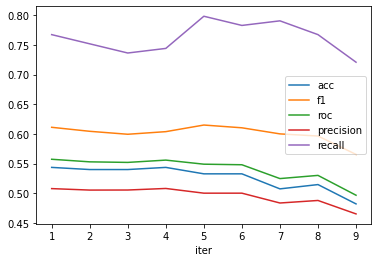

In [ ]:
teststatsdf.plot()
plt.show()

### max_features: no diff

In [ ]:
# max_features
trainstats = []
teststats = []
for i in ['auto','sqrt']:
  rf = ensemble.RandomForestClassifier(random_state=2022, n_estimators=10, max_depth=7, min_samples_split=7, min_samples_leaf=5, max_features=i)
  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)

  trainmetrics = all_metrics(y_train, y_train_pred, i)
  testmetrics = all_metrics(y_test, y_test_pred, i)

  trainstats.append(trainmetrics)
  teststats.append(testmetrics)

In [ ]:
teststatsdf = pd.DataFrame.from_records(teststats)
teststatsdf = teststatsdf.set_index('iter')
teststatsdf

,acc,f1,roc,precision,recall
iter,,,,,
auto,0.532609,0.614925,0.548885,0.5,0.79845
sqrt,0.532609,0.614925,0.548885,0.5,0.79845


### bootstrap: best=True

In [ ]:
# max_features
trainstats = []
teststats = []
for i in [True, False]:
  rf = ensemble.RandomForestClassifier(random_state=2022, n_estimators=10, max_depth=7, min_samples_split=7, min_samples_leaf=5,bootstrap=i)
  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)

  trainmetrics = all_metrics(y_train, y_train_pred, i)
  testmetrics = all_metrics(y_test, y_test_pred, i)

  trainstats.append(trainmetrics)
  teststats.append(testmetrics)

In [ ]:
teststatsdf = pd.DataFrame.from_records(teststats)
teststatsdf = teststatsdf.set_index('iter')
teststatsdf

,acc,f1,roc,precision,recall
iter,,,,,
True,0.532609,0.614925,0.548885,0.500000,0.79845
False,0.514493,0.593939,0.529505,0.487562,0.75969


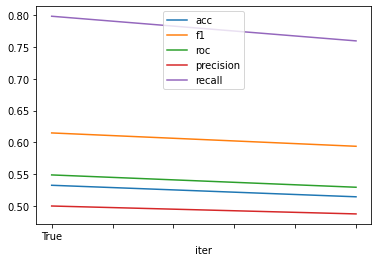

In [ ]:
teststatsdf.plot()
plt.show()

## best model with manual tuning

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=10, random_state=2022, min_samples_leaf=5, min_samples_split=7, max_depth=7, bootstrap=True)
rf.fit(X_train, y_train)

evaluation(y_train, rf.predict(X_train), "Default rf on train dataset")

y_pred_class = rf.predict(X_test)
evaluation(y_test, y_pred_class, "Default rf on test dataset")

================== Evaluation on Default rf on train dataset ==================
accuracy: 0.619105199516324

classification report: 
              precision    recall  f1-score   support

           0       0.66      0.42      0.52      1193
           1       0.60      0.80      0.69      1288

    accuracy                           0.62      2481
   macro avg       0.63      0.61      0.60      2481
weighted avg       0.63      0.62      0.60      2481


F1 score: 
0.6859421734795613

Confusion matrix: 
[[ 504  689]
 [ 256 1032]]

ROC AUC: 0.611853305774367

Precision: 0.599651365485183

================== End of Evaluation on Default rf on train dataset ==================
================== Evaluation on Default rf on test dataset ==================
accuracy: 0.532608695652174

classification report: 
              precision    recall  f1-score   support

           0       0.63      0.30      0.41       147
           1       0.50      0.80      0.61       129

    accuracy        

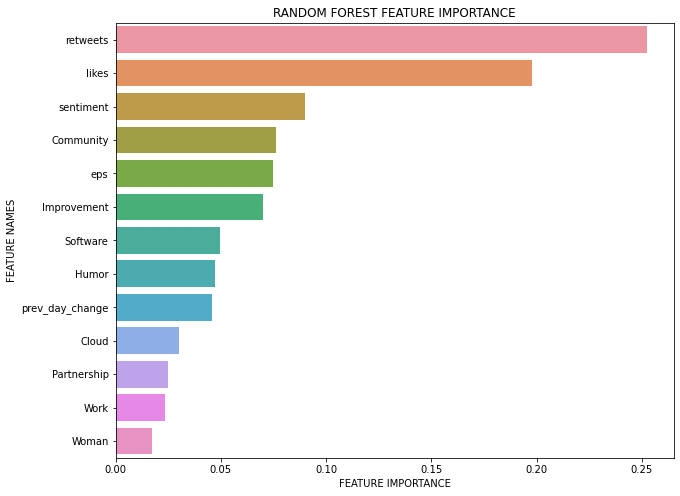

In [ ]:
plot_feature_importance(list(rf.feature_importances_),list(X_train.columns),'RANDOM FOREST ')